In [2]:
from google.colab import drive;
drive.mount('/content/drive')

Mounted at /content/drive


The Dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users. The goal is then to predict which previously purchased products will be in a user’s next order. Now let's jump straight into the data and do some exploratory analysis.

In [3]:
# import the needed librairies
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting

import seaborn as sns
color = sns.color_palette()

import warnings
warnings.filterwarnings('ignore') #Supress unnecessary warnings for readability and cleaner presentation

pd.set_option('display.float_format', lambda x: '%.3f' % x) #Limiting floats output to 3 decimal points

In [4]:
# Now let's get and put the data in  pandas dataframe
order_products_train = pd.read_csv('/content/drive/MyDrive/Instacart_Basket_Analysis/data/order_products__train.csv')
order_products_prior = pd.read_csv('/content/drive/MyDrive/Instacart_Basket_Analysis/data/order_products__prior.csv')
orders = pd.read_csv('/content/drive/MyDrive/Instacart_Basket_Analysis/data/orders.csv')
products = pd.read_csv('/content/drive/MyDrive/Instacart_Basket_Analysis/data/products.csv')
aisles = pd.read_csv('/content/drive/MyDrive/Instacart_Basket_Analysis/data/aisles.csv')
departments = pd.read_csv('/content/drive/MyDrive/Instacart_Basket_Analysis/data/departments.csv')

## Understanding Orders and Products
Firstly, let's explore order_products_train and order_products_prior files. These files specify which products were purchased in each order. More specifically, order_products_prior contains previous order contents for all customers and order_products_train contains the last orders for some customers only.

In [5]:
print("The order_products_train size is : ", order_products_train.shape)
print("The order_products_prior size is : ", order_products_prior.shape)

The order_products_train size is :  (1384617, 4)
The order_products_prior size is :  (32434489, 4)


In [6]:
# display first five rows.
order_products_train.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [7]:
# display first five rows.
order_products_prior.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


Now, let's concatenate them in the same order_products dataframe.

In [8]:
order_products_all = pd.concat([order_products_train, order_products_prior], axis=0)
print("The order_products_all size is : ", order_products_all.shape)

The order_products_all size is :  (33819106, 4)


In [9]:
# display first five rows.
order_products_all.head(5)

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


**Handling Missing data**

In [11]:
total = order_products_all.isnull().sum().sort_values(ascending=False)
percent = (order_products_all.isnull().sum()/order_products_all.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total Missing', 'Percent'])
missing_data

,Total Missing,Percent
order_id,0,0.000
product_id,0,0.000
add_to_cart_order,0,0.000
reordered,0,0.000


In [12]:
# Check the number of unique orders and unique products
orders_Unique = len(set(order_products_all.order_id))
products_Unique = len(set(order_products_all.product_id))
print("There are %s orders for %s products" %(orders_Unique, products_Unique))

There are 3346083 orders for 49685 products


Let us see Number of products that people usually order in each instacart order

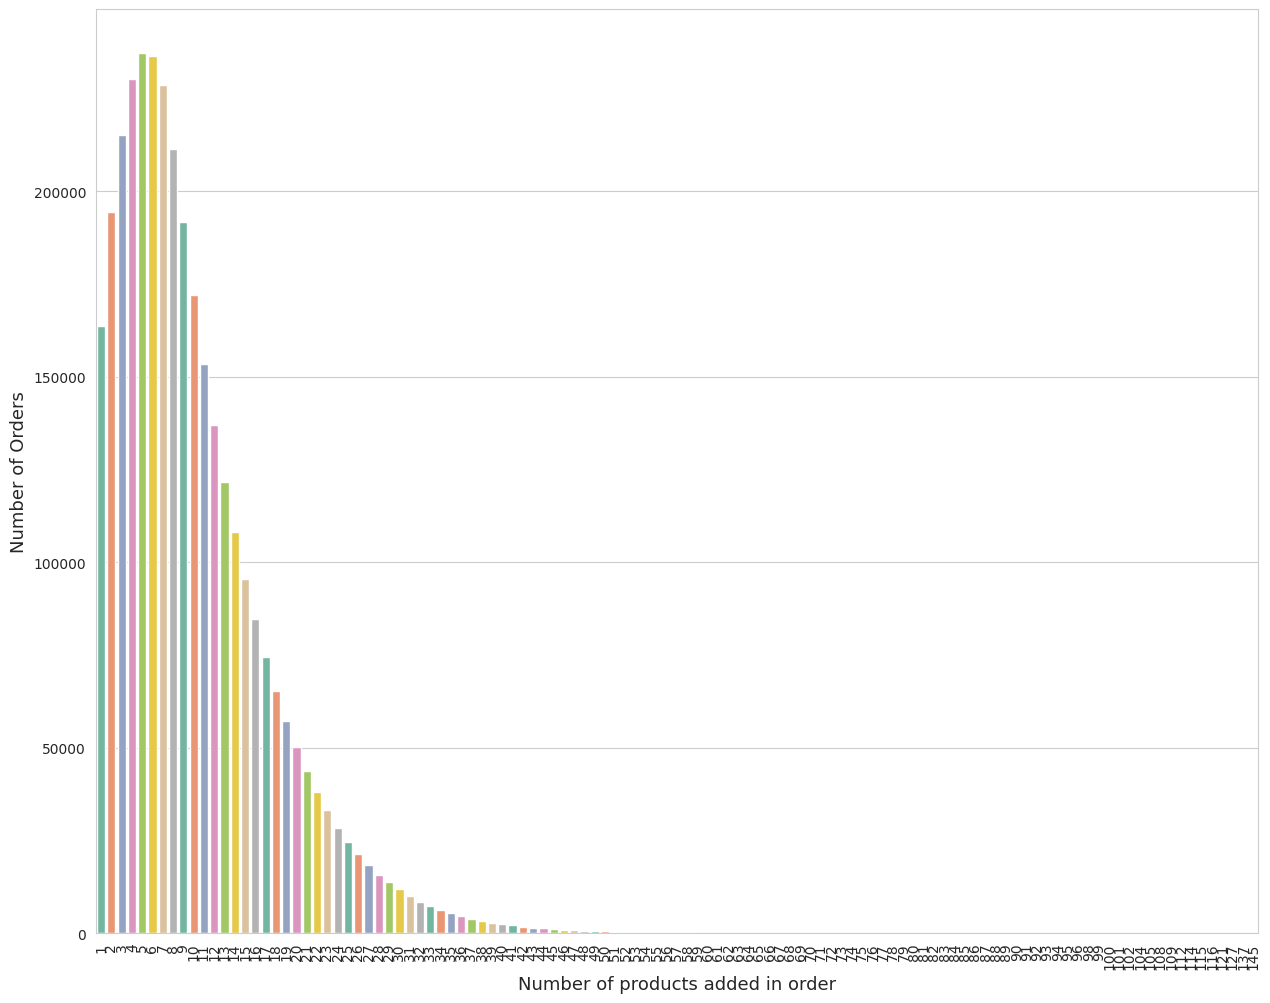

In [124]:
grouped = order_products_all.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
grouped = grouped.add_to_cart_order.value_counts()

sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='vertical')
sns.barplot(x=grouped.index, y= grouped.values, palette= 'Set2')

plt.ylabel('Number of Orders', fontsize=13)
plt.xlabel('Number of products added in order', fontsize=13)
plt.show()

We can observe that people usually order around 5 products.

Most ordered Products: let's identify which products are ordered the most.

In [122]:
grouped = order_products_all.groupby("product_id").agg(Total_reorders=('reordered', 'count')).reset_index()
grouped = pd.merge(grouped, products[['product_id', 'product_name']], how='left', on=['product_id'])
grouped = grouped.sort_values(by='Total_reorders', ascending=False)[:10]
grouped

,product_id,Total_reorders,product_name
24849,24852,491291,Banana
13173,13176,394930,Bag of Organic Bananas
21134,21137,275577,Organic Strawberries
21900,21903,251705,Organic Baby Spinach
47205,47209,220877,Organic Hass Avocado
47762,47766,184224,Organic Avocado
47622,47626,160792,Large Lemon
16794,16797,149445,Strawberries
26206,26209,146660,Limes
27842,27845,142813,Organic Whole Milk


Let us visualize the products that were ordered the most.

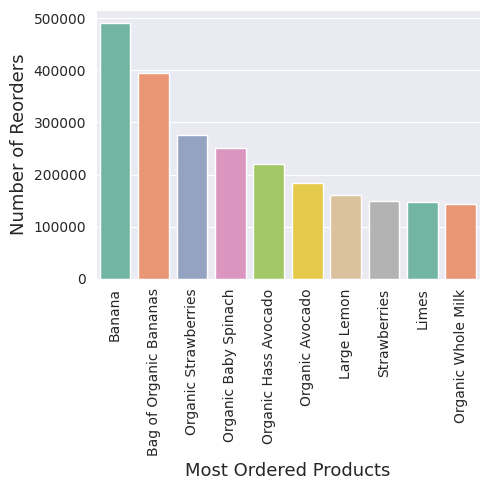

In [123]:
sns.set_style('darkgrid')
plt.figure(figsize=(5, 5))
sns.barplot(x='product_name', y='Total_reorders', data=grouped, palette= 'Set2')
plt.xticks(rotation=90)
plt.ylabel('Number of Reorders', fontsize=13)
plt.xlabel('Most Ordered Products', fontsize=13)
plt.tight_layout()
plt.show()

Do people usually reorder the same previous ordered products?

In [41]:
grouped = order_products_all.groupby("reordered").agg(Total_products=('product_id', 'count')).reset_index()
grouped['Ratios'] = grouped["Total_products"] / grouped["Total_products"].sum()
grouped

,reordered,Total_products,Ratios
0,0,13863746,0.410
1,1,19955360,0.590


59% of ordered products are previously ordered by customers.

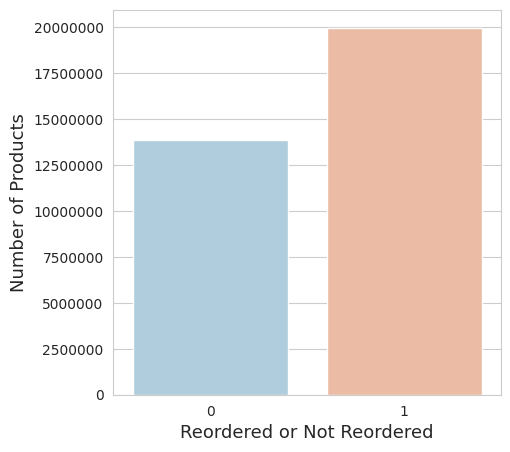

In [44]:

sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(5, 5))
sns.barplot(x= grouped.index, y= grouped.values, palette='RdBu_r')
plt.ylabel('Number of Products', fontsize=13)
plt.xlabel('Reordered or Not Reordered', fontsize=13)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

**Most Reordered Products** \\
Which products are usually reordered?

In [120]:
grouped = order_products_all.groupby("product_id").agg(
    reorder_sum=('reordered', 'sum'),
    reorder_total=('reordered', 'count')
).reset_index()

grouped['reorder_probability'] = grouped['reorder_sum'] / grouped['reorder_total']

grouped = pd.merge(grouped, products[['product_id', 'product_name']], how='left', on='product_id')

grouped = grouped[grouped['reorder_total'] > 75].sort_values('reorder_probability', ascending=False).head(10)

grouped

,product_id,reorder_sum,reorder_total,reorder_probability,product_name
2074,2075,84,90,0.933,Serenity Ultimate Extrema Overnight Pads
27737,27740,94,102,0.922,Chocolate Love Bar
35601,35604,93,104,0.894,Maca Buttercups
38248,38251,99,111,0.892,Benchbreak Chardonnay
36798,36801,88,99,0.889,Organic Blueberry B Mega
10233,10236,114,131,0.870,Fragrance Free Clay with Natural Odor Eliminat...
20595,20598,99,114,0.868,Thousand Island Salad Snax
5455,5457,78,90,0.867,Classic Carbonated Natural Mineral Water
35493,35496,394,457,0.862,Real2 Alkalized Water 500 ml
9289,9292,2580,2995,0.861,Half And Half Ultra Pasteurized


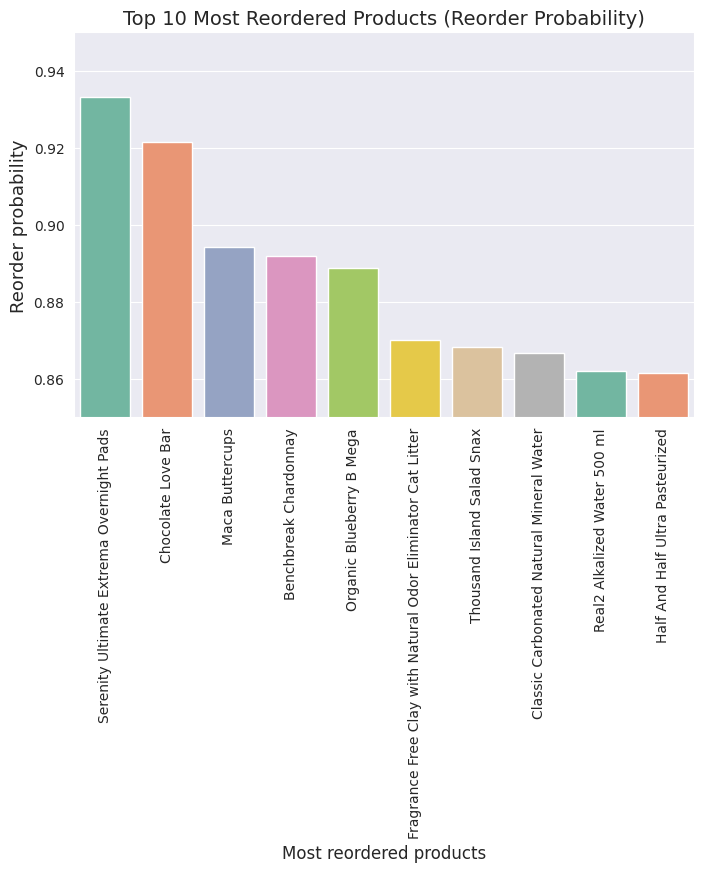

In [121]:
sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(8, 5))
plt.xticks(rotation='vertical')
sns.barplot(x='product_name', y='reorder_probability', data=grouped, palette= 'Set2')
plt.ylim([0.85, 0.95])
plt.ylabel('Reorder probability', fontsize=13)
plt.xlabel('Most reordered products', fontsize=12)
plt.title('Top 10 Most Reordered Products (Reorder Probability)', fontsize=14)
plt.show()

## Understanding Orders

In [54]:
print("The orders data size is : ", orders.shape)
print("Columns in orders data are: ", orders.columns.values)

The orders data size is :  (3421083, 7)
Columns in orders data are:  ['order_id' 'user_id' 'eval_set' 'order_number' 'order_dow'
 'order_hour_of_day' 'days_since_prior_order']


In [55]:
# display first five rows of our dataset.
orders.head(5)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.000
2,473747,1,prior,3,3,12,21.000
3,2254736,1,prior,4,4,7,29.000
4,431534,1,prior,5,4,15,28.000


**Handling missing values**

In [56]:
orders_na = (orders.isnull().sum() / len(orders)) * 100
orders_na = orders_na.drop(orders_na[orders_na == 0].index).sort_values(ascending=False)
orders_na

,0
days_since_prior_order,6.028


The only feature with missing values is days_since_prior_order with 6.028% missing.

**Time at which people usually order products**

Hours of Order in a Day

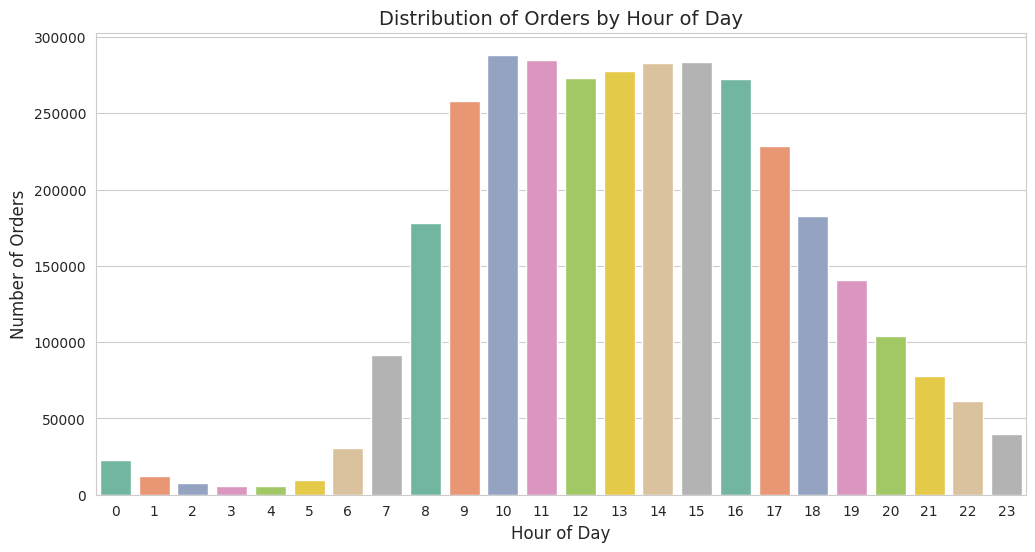

In [118]:
order_counts_by_hour = orders['order_hour_of_day'].value_counts().sort_index()

sns.set_style('whitegrid')
plt.figure(figsize=(12,6))
sns.barplot(x=order_counts_by_hour.index, y=order_counts_by_hour.values, palette= 'Set2')
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.title('Distribution of Orders by Hour of Day', fontsize=14)
plt.show()

Orders in a week

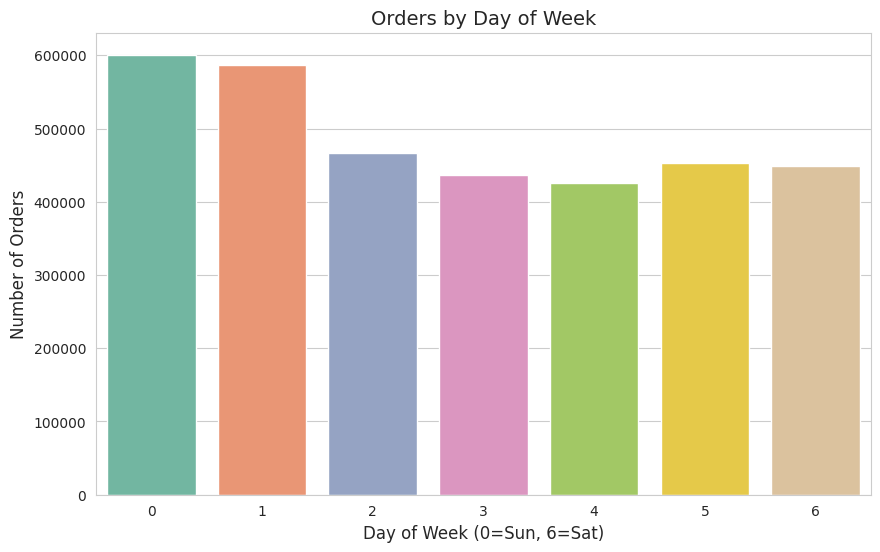

In [117]:
grouped = orders['order_dow'].value_counts().sort_index()

sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
sns.barplot(x=grouped.index, y=grouped.values, palette= 'Set2')
plt.xlabel('Day of Week (0=Sun, 6=Sat)', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.title('Orders by Day of Week', fontsize=14)
plt.show()

Period of Reorders

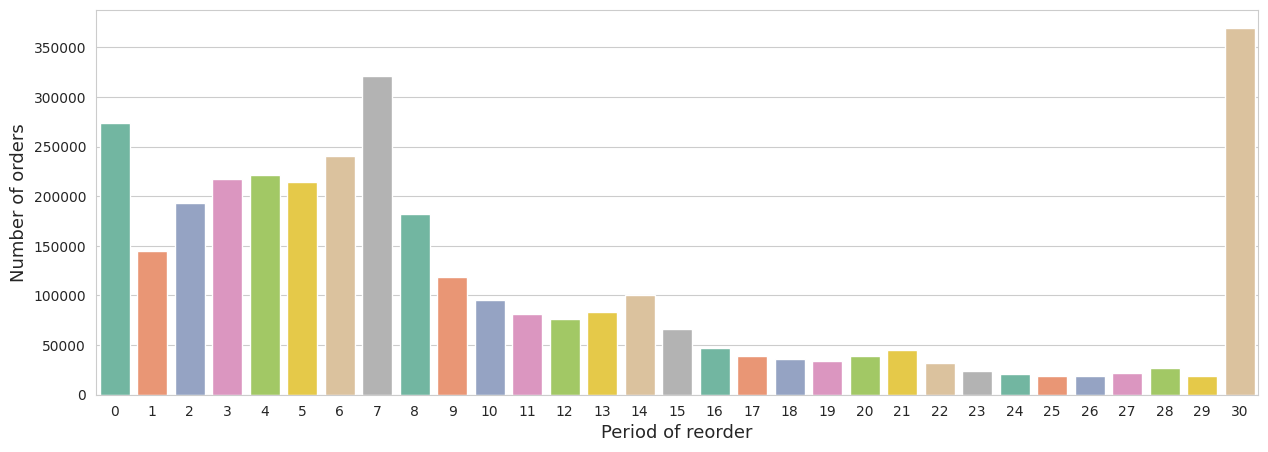

In [116]:
grouped = orders.groupby("order_id")["days_since_prior_order"].agg("sum").reset_index()
grouped = grouped.days_since_prior_order.value_counts()

from matplotlib.ticker import FormatStrFormatter
f, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x= grouped.index, y= grouped.values, palette= 'Set2')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.ylabel('Number of orders', fontsize=13)
plt.xlabel('Period of reorder', fontsize=13)
plt.show()

People usually reorder either after 1 week or after 1 month.

## Understanding the whole dataset

**Orders in the whole dataset**

Number and ratio of orders from the three datasets (prior, train, test).

In [68]:
grouped = orders.groupby("eval_set")["order_id"].agg(Total_orders='count').reset_index()
grouped['Ratio'] = grouped["Total_orders"] / grouped["Total_orders"].sum()
grouped

,eval_set,Total_orders,Ratio
0,prior,3214874,0.940
1,test,75000,0.022
2,train,131209,0.038


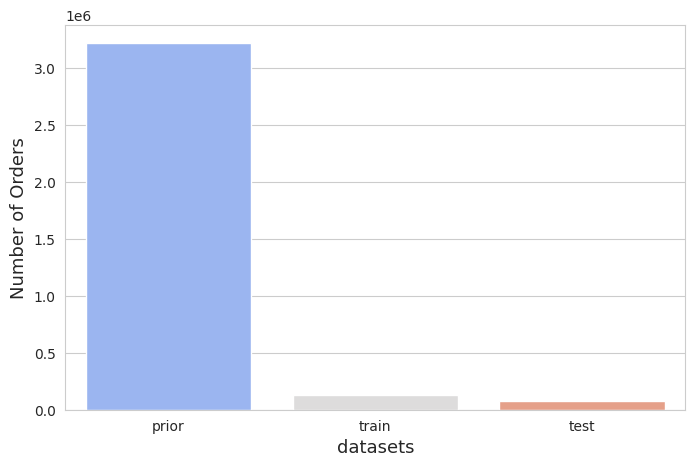

In [69]:
grouped  = grouped.groupby(['eval_set']).sum()['Total_orders'].sort_values(ascending=False)

sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x= grouped.index, y= grouped.values, palette='coolwarm')
plt.ylabel('Number of Orders', fontsize=13)
plt.xlabel('datasets', fontsize=13)
plt.show()

**Customers in the whole dataset**


Let's check the total number of unique customers in the three datasets (prior, train, test).

In [70]:
print("Number of unique customers in the whole dataset: ",len(set(orders.user_id)))

Number of unique customers in the whole dataset:  206209


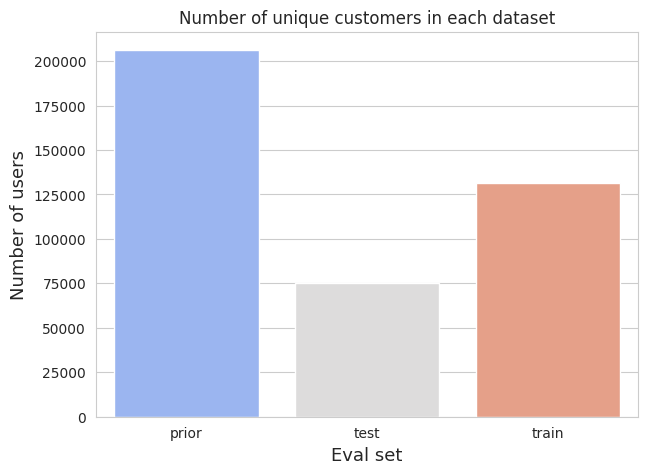

In [73]:
grouped = orders.groupby("eval_set")["user_id"].apply(lambda x: len(x.unique()))

plt.figure(figsize=(7,5))
sns.barplot(x= grouped.index, y= grouped.values, palette='coolwarm')
plt.ylabel('Number of users', fontsize=13)
plt.xlabel('Eval set', fontsize=13)
plt.title("Number of unique customers in each dataset")
plt.show()

Orders made by each customer

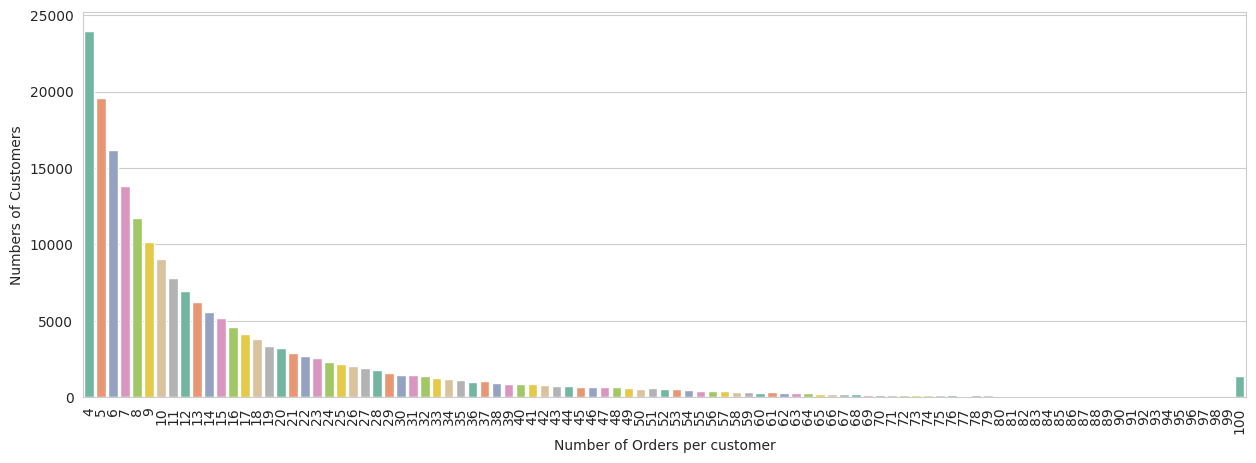

In [115]:
grouped = orders.groupby('user_id')['order_id'].apply(lambda x: len(x.unique())).reset_index()
grouped = grouped.groupby('order_id').aggregate("count")

sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x= grouped.index, y= grouped.user_id, palette= 'Set2')
plt.ylabel('Numbers of Customers')
plt.xlabel('Number of Orders per customer')
plt.xticks(rotation='vertical')
plt.show()

We can observe that most customers made 4 orders.

## Understanding products, departments and aisles datasets

In [79]:
products.head(5)

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [80]:
departments.head(5)

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [81]:
aisles.head(5)

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [82]:
items = pd.merge(left =pd.merge(left=products, right=departments, how='left'), right=aisles, how='left')
items.head()

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,2,All-Seasons Salt,104,13,pantry,spices seasonings
2,3,Robust Golden Unsweetened Oolong Tea,94,7,beverages,tea
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen,frozen meals
4,5,Green Chile Anytime Sauce,5,13,pantry,marinades meat preparation


**Most important Departments (by number of products)**

In [83]:
grouped = items.groupby("department")["product_id"].agg(Total_products= 'count').reset_index()
grouped['Ratio'] = grouped["Total_products"].apply(lambda x: x /grouped['Total_products'].sum())
grouped.sort_values(by='Total_products', ascending=False, inplace=True)
grouped

,department,Total_products,Ratio
17,personal care,6563,0.132
20,snacks,6264,0.126
16,pantry,5371,0.108
3,beverages,4365,0.088
10,frozen,4007,0.081
7,dairy eggs,3449,0.069
11,household,3085,0.062
6,canned goods,2092,0.042
9,dry goods pasta,1858,0.037
19,produce,1684,0.034


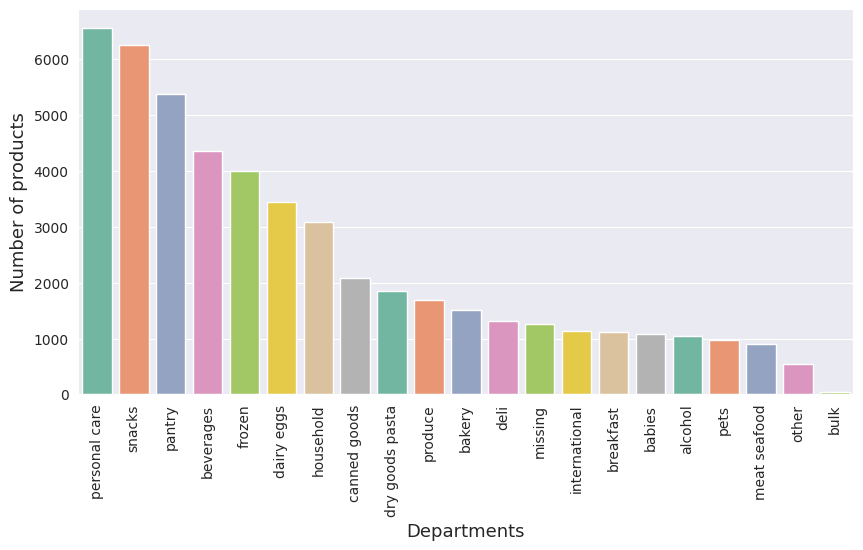

In [114]:
grouped = grouped.groupby(['department']).sum()['Total_products'].sort_values(ascending=False)

sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10, 5))
plt.xticks(rotation='vertical')
sns.barplot(x= grouped.index, y= grouped.values, palette= 'Set2')
plt.ylabel('Number of products', fontsize=13)
plt.xlabel('Departments', fontsize=13)
plt.show()

**Most important Aisles in each Department (by number of Products)**

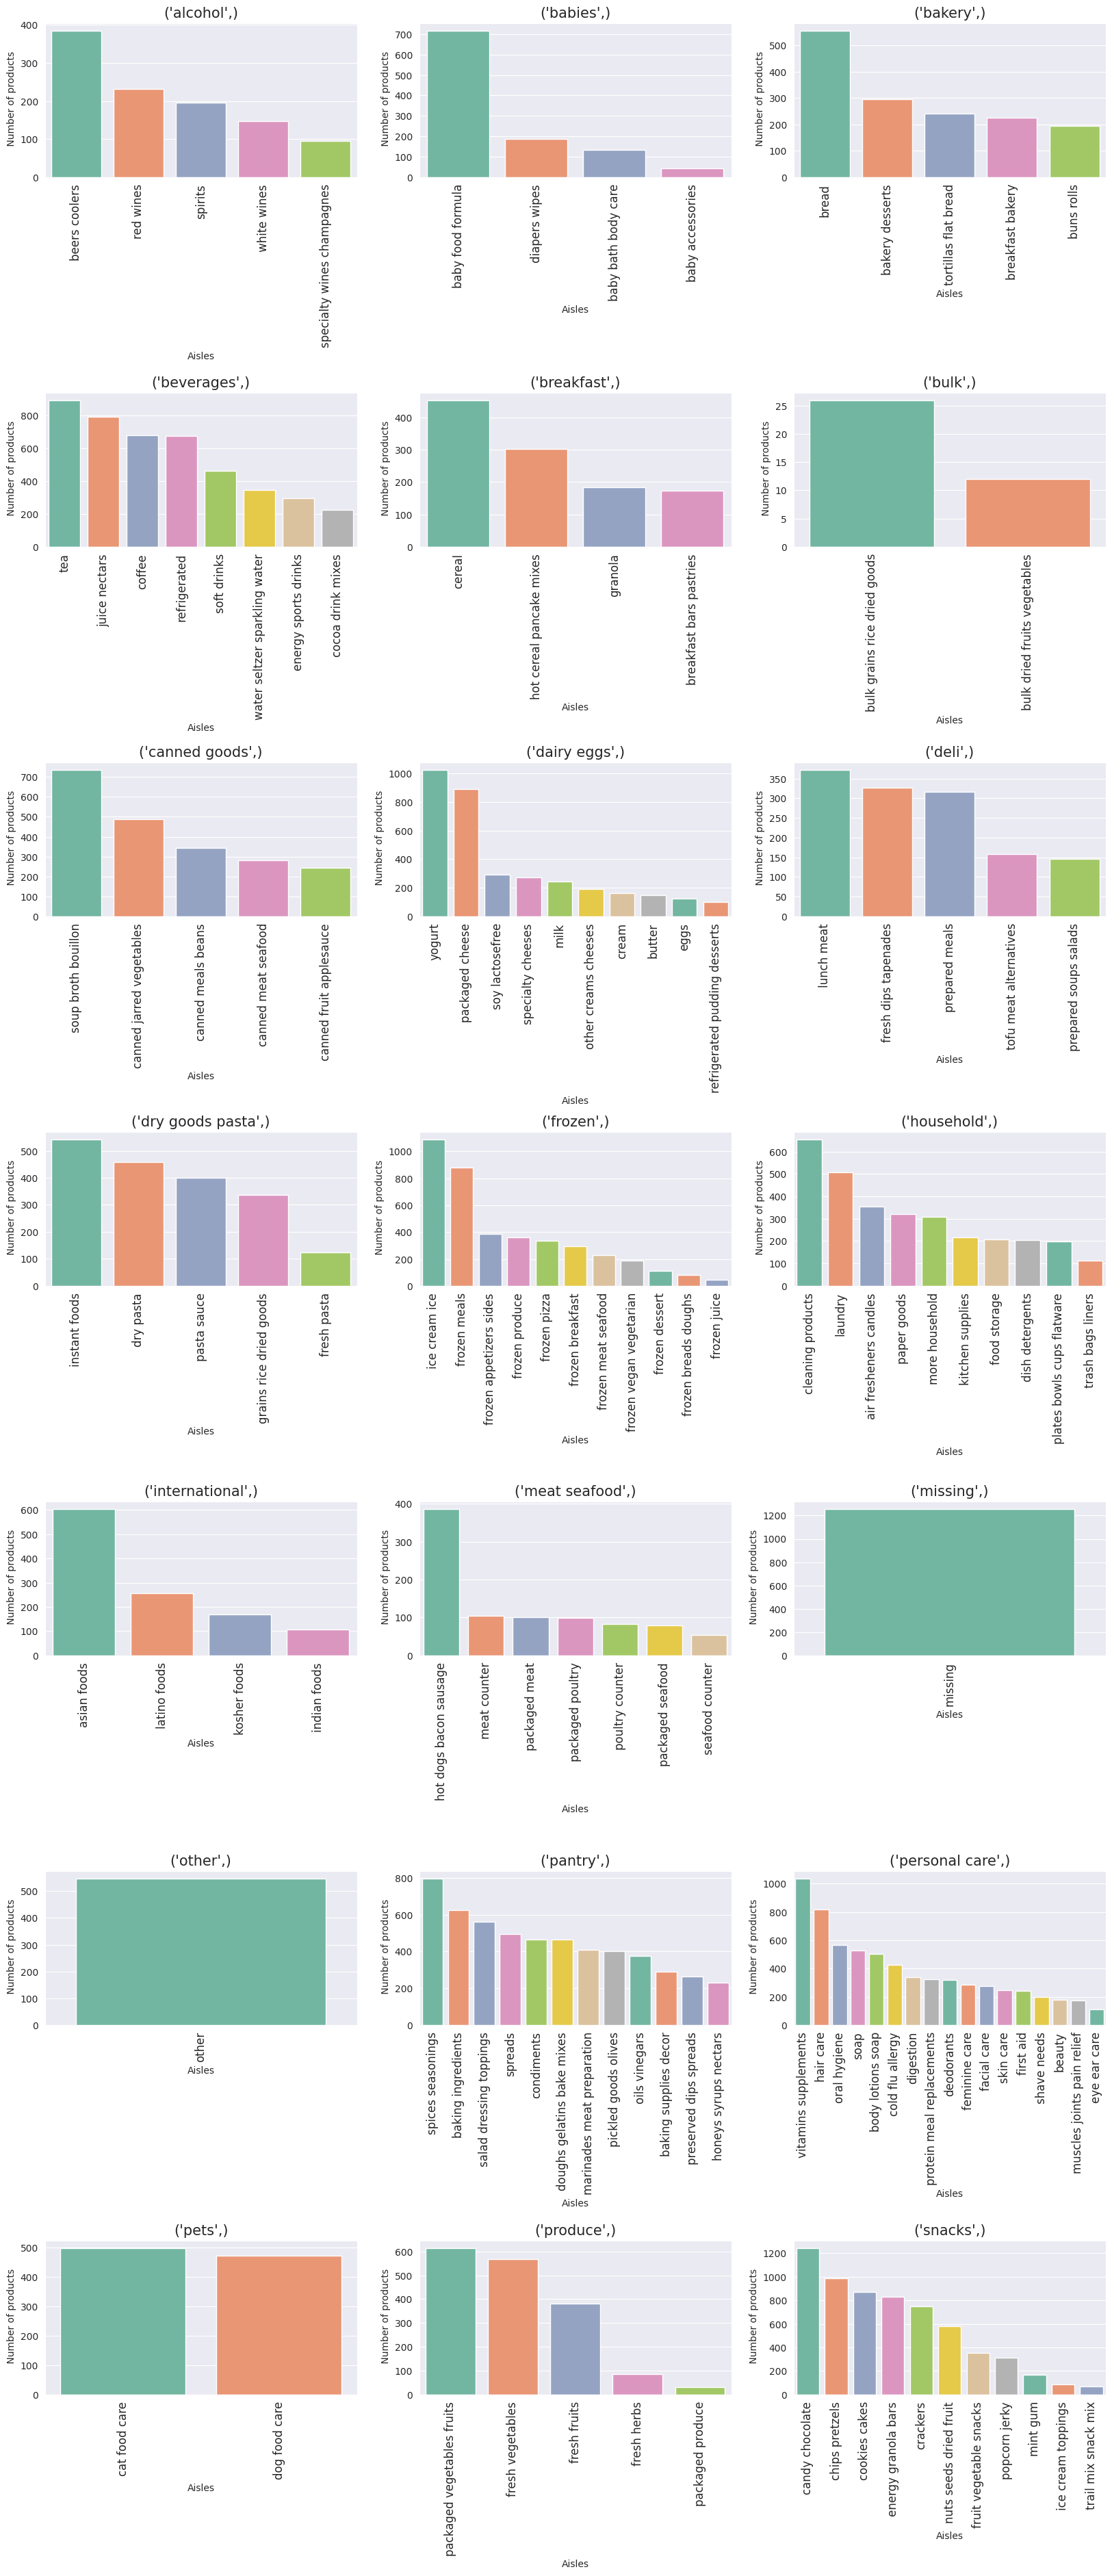

In [113]:
grouped = items.groupby(["department", "aisle"])["product_id"].agg(Total_products= 'count').reset_index()

grouped.sort_values(by='Total_products', ascending=False, inplace=True)

fig, axes = plt.subplots(7,3, figsize=(20,45), gridspec_kw =  dict(hspace=1.4))

for (aisle, group), ax in zip(grouped.groupby(["department"]), axes.flatten()):
    g = sns.barplot(x= group.aisle, y= group.Total_products , ax=ax, palette= 'Set2')
    ax.set(xlabel = "Aisles", ylabel=" Number of products")
    g.set_xticklabels(labels = group.aisle,rotation=90, fontsize=12)
    ax.set_title(aisle, fontsize=15)

**Most important Aisles over all Departments (by number of Products)**

In [111]:
grouped = items.groupby("aisle")["product_id"].aggregate(Total_products= 'count').reset_index()
grouped['Ratio'] = grouped["Total_products"].apply(lambda x: x /grouped['Total_products'].sum())
grouped = grouped.sort_values(by='Total_products', ascending=False)[:20]
grouped

,aisle,Total_products,Ratio
85,missing,1258,0.025
18,candy chocolate,1246,0.025
71,ice cream ice,1091,0.022
130,vitamins supplements,1038,0.021
133,yogurt,1026,0.021
25,chips pretzels,989,0.020
125,tea,894,0.018
93,packaged cheese,891,0.018
59,frozen meals,880,0.018
31,cookies cakes,874,0.018


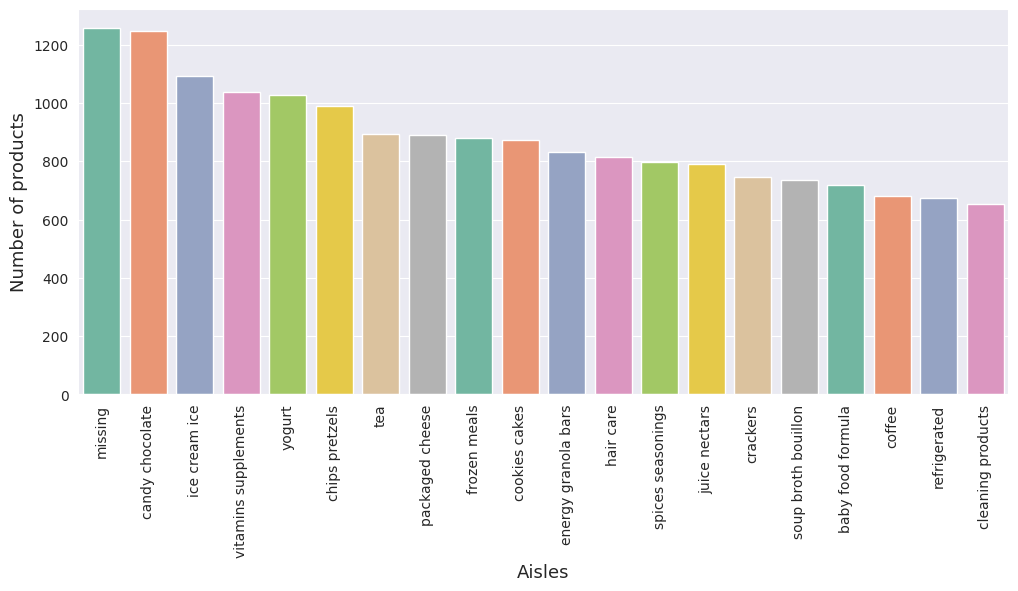

In [112]:
grouped  = grouped.groupby(['aisle']).sum()['Total_products'].sort_values(ascending=False)

f, ax = plt.subplots(figsize=(12, 5))
plt.xticks(rotation='vertical')
sns.barplot(x= grouped.index, y= grouped.values, palette= 'Set2')
plt.ylabel('Number of products', fontsize=13)
plt.xlabel('Aisles', fontsize=13)
plt.show()

What are customers' favorite Departments and Aisles?

In [93]:
users_flow = orders[['user_id', 'order_id']].merge(order_products_train[['order_id', 'product_id']],
                                          how='inner', left_on='order_id', right_on='order_id')
users_flow = users_flow.merge(items, how='inner', left_on='product_id',
                                         right_on='product_id')

Best Selling Departments (number of Orders)

In [108]:
grouped = users_flow.groupby("department")["order_id"].agg(Total_orders= 'count').reset_index()
grouped['Ratio'] = grouped["Total_orders"].apply(lambda x: x /grouped['Total_orders'].sum())
grouped.sort_values(by='Total_orders', ascending=False, inplace=True)
grouped

,department,Total_orders,Ratio
19,produce,409087,0.295
7,dairy eggs,217051,0.157
20,snacks,118862,0.086
3,beverages,114046,0.082
10,frozen,100426,0.073
16,pantry,81242,0.059
2,bakery,48394,0.035
6,canned goods,46799,0.034
8,deli,44291,0.032
9,dry goods pasta,38713,0.028


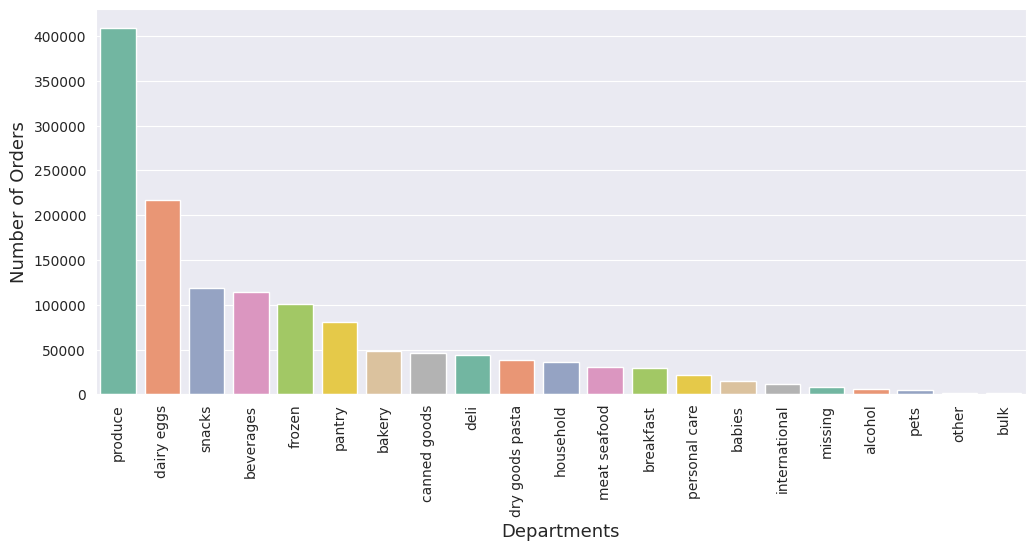

In [109]:
grouped = grouped.groupby(['department']).sum()['Total_orders'].sort_values(ascending=False)

f, ax = plt.subplots(figsize=(12, 5))
plt.xticks(rotation='vertical')
sns.barplot(x= grouped.index, y= grouped.values, palette= 'Set2')
plt.ylabel('Number of Orders', fontsize=13)
plt.xlabel('Departments', fontsize=13)
plt.show()

Best Selling Aisles in each Department (by number of Orders)

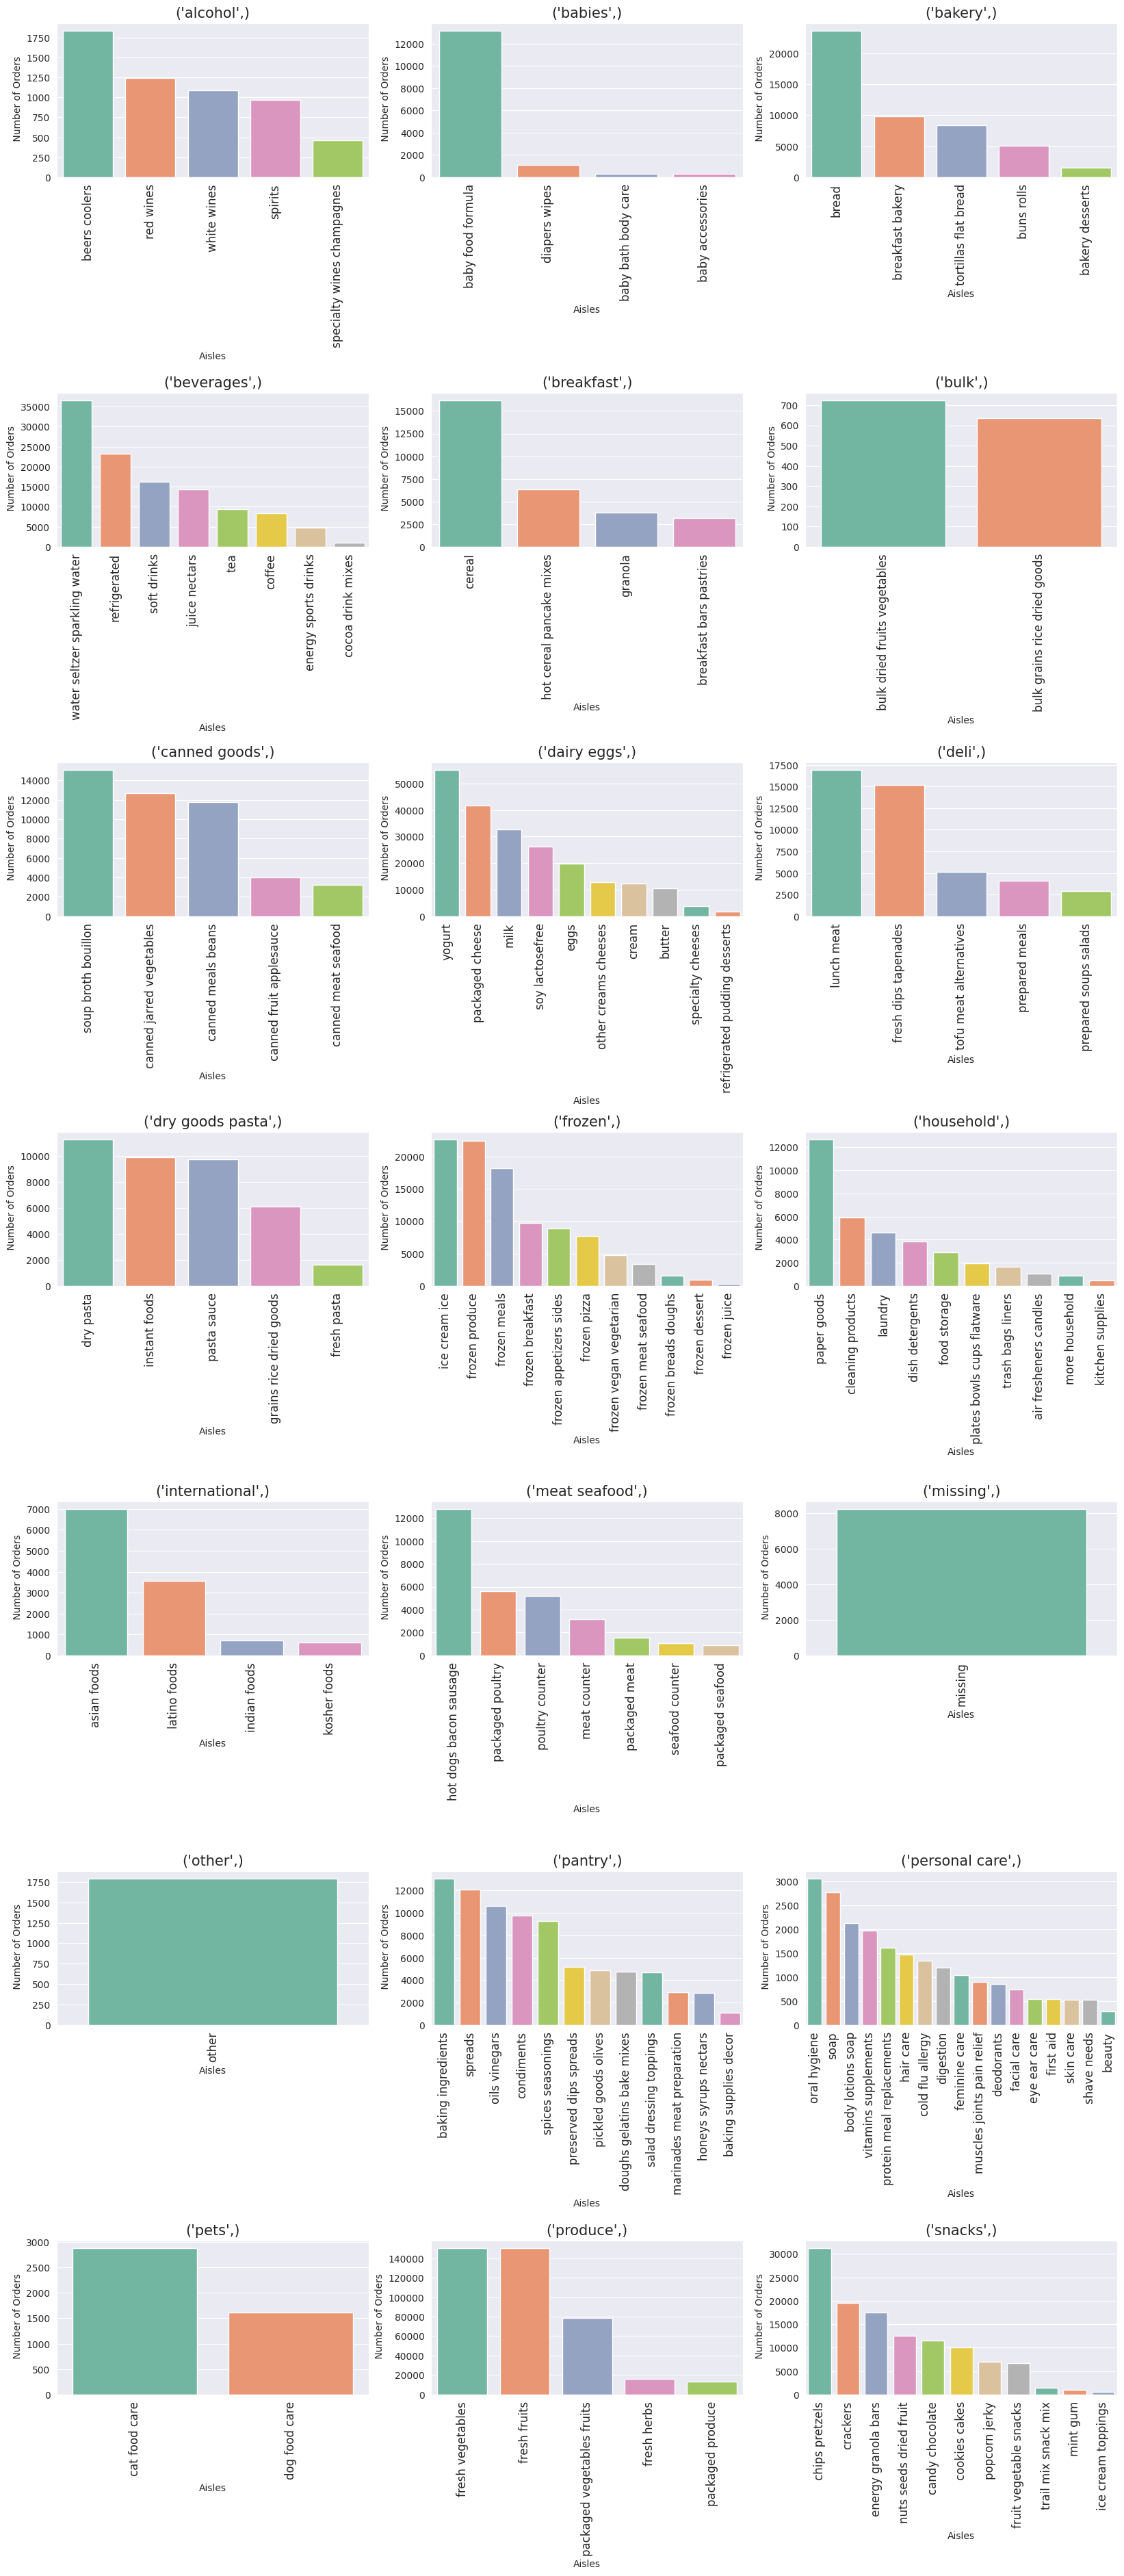

In [107]:
grouped = users_flow.groupby(["department", "aisle"])["order_id"].agg(Total_orders= 'count').reset_index()

grouped.sort_values(by='Total_orders', ascending=False, inplace=True)

fig, axes = plt.subplots(7,3, figsize=(20,45), gridspec_kw =  dict(hspace=1.4))

for (aisle, group), ax in zip(grouped.groupby(["department"]), axes.flatten()):
    g = sns.barplot(x= group.aisle, y= group.Total_orders , ax=ax, palette= 'Set2')
    ax.set(xlabel = "Aisles", ylabel=" Number of Orders")
    g.set_xticklabels(labels = group.aisle,rotation=90, fontsize=12)
    ax.set_title(aisle, fontsize=15)

Best Selling Aisles over all Departments

In [104]:
grouped = users_flow.groupby("aisle")["order_id"].aggregate(Total_orders= 'count').reset_index()
grouped['Ratio'] = grouped["Total_orders"].apply(lambda x: x /grouped['Total_orders'].sum())
grouped.sort_values(by='Total_orders', ascending=False, inplace=True )
grouped.head(10)

,aisle,Total_orders,Ratio
53,fresh vegetables,150609,0.109
50,fresh fruits,150473,0.109
98,packaged vegetables fruits,78493,0.057
133,yogurt,55240,0.040
93,packaged cheese,41699,0.030
131,water seltzer sparkling water,36617,0.026
83,milk,32644,0.024
25,chips pretzels,31269,0.023
119,soy lactosefree,26240,0.019
11,bread,23635,0.017


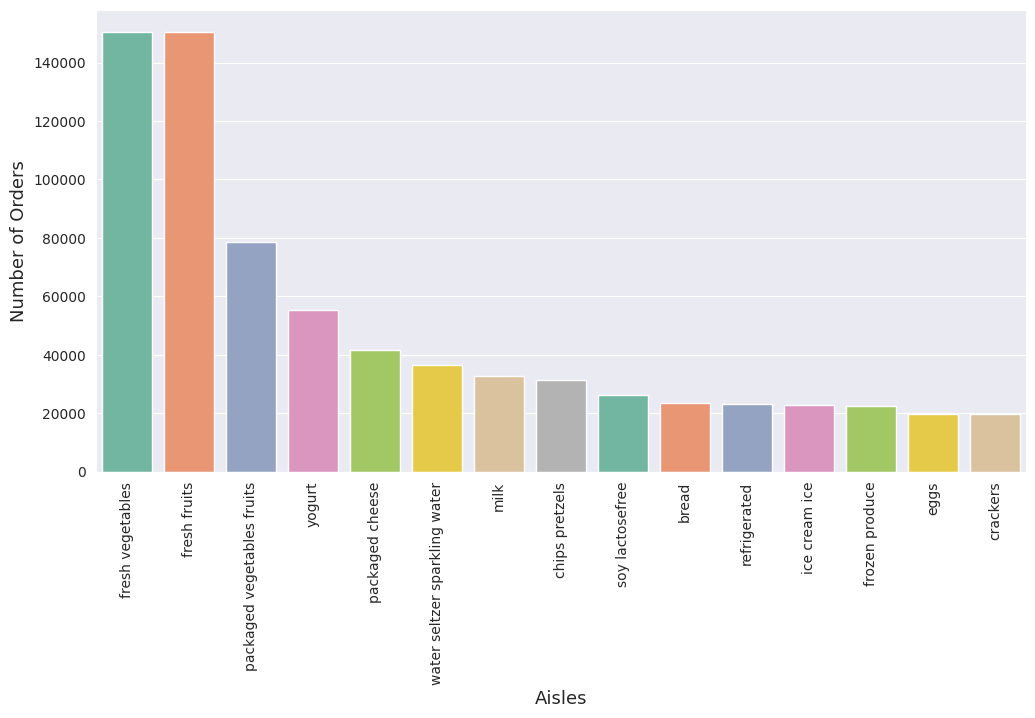

In [105]:
grouped = grouped.groupby(['aisle']).sum()['Total_orders'].sort_values(ascending=False)[:15]

f, ax = plt.subplots(figsize=(12, 6))
plt.xticks(rotation='vertical')
sns.barplot(x= grouped.index, y= grouped.values, palette= 'Set2')
plt.ylabel('Number of Orders', fontsize=13)
plt.xlabel('Aisles', fontsize=13)
plt.show()